# Classification using Cyclic Boosting

First, install the  package and its dependencies

```sh
!pip install cyclic-boosting
```

In [1]:
# Optional formatting if juypter-black is installed
try:
    import jupyter_black

    jupyter_black.load()
except ImportError:
    ...

In [49]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import OrdinalEncoder

from cyclic_boosting import flags, common_smoothers, observers
from cyclic_boosting.plots import plot_analysis
from cyclic_boosting.pipelines import pipeline_CBClassifier
from typing import List, Tuple

Let's load the adult census income dataset from OpenML

In [3]:
from sklearn.datasets import fetch_openml

data = fetch_openml(data_id=1590)

/Users/luis.ventura/Library/Caches/pypoetry/virtualenvs/cyclic-boosting-aq1wCJ_X-py3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [29]:
# Read the DataFrame, first using the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)  # Add a target column, and fill it with the target data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [30]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [31]:
exploration_variables = ["race", "sex", "native-country"]
agg_summary = {
    key: df.groupby(key).agg({"age": "count"}).sort_values(by="age", ascending=False).head(+10)
    for key in exploration_variables
}

In [36]:
for key in agg_summary.keys():
    print(agg_summary[key] / agg_summary[key].sum())

                         age
race                        
White               0.855043
Black               0.095922
Asian-Pac-Islander  0.031100
Amer-Indian-Eskimo  0.009623
Other               0.008313
             age
sex             
Male    0.668482
Female  0.331518
                     age
native-country          
United-States   0.948314
Mexico          0.020575
Philippines     0.006382
Germany         0.004457
Puerto-Rico     0.003981
Canada          0.003938
El-Salvador     0.003353
India           0.003267
Cuba            0.002986
England         0.002748


For convenience we split the columns into two groups, categorical and continuous

In [92]:
cols_categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
cols_noncategorical = [n for n in df.columns if (n not in cols_categorical) and (n != "target")]

In [93]:
cols_noncategorical

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

Adding the target column to the dataframe and convert to 0 and 1

In [94]:
df["target"] = data.target.eq(">50K").mul(1)

In [95]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'target'],
      dtype='object')

In [96]:
assert set(cols_noncategorical + cols_categorical) - set(df.columns) == set(), "Columns not in data set"
print("unused columns:", set(df.columns) - set(cols_noncategorical + cols_categorical))

unused columns: {'target'}


# Prepare the data

The data has to be prepared for the training. We want to convert the categorical variables into numerical values using the scikit-learn OrdinalEncoder (guess, who contributed this 😜).

In [97]:
def prepare_data(df: pd.DataFrame, cols_categorical: List[str]) -> Tuple[pd.DataFrame, np.array]:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

    input_df = df.drop(columns=["target"])
    df_categoricals = pd.DataFrame(enc.fit_transform(input_df[cols_categorical]), columns=cols_categorical)
    df_non_categoricals = input_df[[col for col in input_df.columns if col not in cols_categorical]]

    X = pd.concat([df_categoricals, df_non_categoricals], axis=1)
    y = np.asarray(df["target"])

    return X, y

In [98]:
X, y = prepare_data(df=df, cols_categorical=cols_categorical)

In [99]:
X.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,3.0,1.0,4.0,6.0,3.0,2.0,1.0,38.0,25.0,226802.0,7.0,0.0,0.0,40.0
1,3.0,11.0,2.0,4.0,0.0,4.0,1.0,38.0,38.0,89814.0,9.0,0.0,0.0,50.0
2,1.0,7.0,2.0,10.0,0.0,4.0,1.0,38.0,28.0,336951.0,12.0,0.0,0.0,40.0
3,3.0,15.0,2.0,6.0,0.0,2.0,1.0,38.0,44.0,160323.0,10.0,7688.0,0.0,40.0
4,NaN,15.0,4.0,NaN,3.0,4.0,0.0,38.0,18.0,103497.0,10.0,0.0,0.0,30.0


In [100]:
y[:5]

array([0, 0, 1, 1, 0])

# Set the feature properties

We need to tell Cyclic Boosting which feature to use and what type of feature these are and how to handle them.

We want the continuous features be `IS_CONTINUOUS` with missing values (very handy, isn't it 😎) and the categorical features to be treated as unordered classes (no neighboring relation as in weekdays for example).

Note: there is next to no feature engineering done here deliberately. Checking the feature carefully, there can be potentially improved a lot by treating the features individually and maybe even combing them into 2D features (see documentation). We just want to get it up-and-running here.

In [101]:
features = cols_categorical + cols_noncategorical

feature_properties = {
    **{col: flags.IS_UNORDERED | flags.HAS_MISSING | flags.MISSING_NOT_LEARNED for col in cols_categorical},
    **{col: flags.IS_CONTINUOUS | flags.HAS_MISSING | flags.MISSING_NOT_LEARNED for col in cols_noncategorical},
}
features, feature_properties

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country',
  'age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 {'workclass': 52,
  'education': 52,
  'marital-status': 52,
  'occupation': 52,
  'relationship': 52,
  'race': 52,
  'sex': 52,
  'native-country': 52,
  'age': 49,
  'fnlwgt': 49,
  'education-num': 49,
  'capital-gain': 49,
  'capital-loss': 49,
  'hours-per-week': 49})

In [102]:
feature_properties

{'workclass': 52,
 'education': 52,
 'marital-status': 52,
 'occupation': 52,
 'relationship': 52,
 'race': 52,
 'sex': 52,
 'native-country': 52,
 'age': 49,
 'fnlwgt': 49,
 'education-num': 49,
 'capital-gain': 49,
 'capital-loss': 49,
 'hours-per-week': 49}

# Build the model

The model is implemented as a scikit-learn pipeline, stitching together a Binner and the CB classifier estimator. Most notably, we reduce the number of used bins in all continuous features to 10 instead of 100, should be plenty.

In [103]:
def cb_classifier_model():
    plobs = [observers.PlottingObserver(iteration=-1)]

    CB_pipeline = pipeline_CBClassifier(
        feature_properties=feature_properties,
        feature_groups=features,
        observers=plobs,
        maximal_iterations=50,
        number_of_bins=10,
        smoother_choice=common_smoothers.SmootherChoiceGroupBy(
            use_regression_type=True,
            use_normalization=False,
        ),
    )

    return CB_pipeline

In [104]:
CB_est = cb_classifier_model()

CB_est

Pipeline(steps=[('binning',
                 BinNumberTransformer(feature_properties={'age': 49,
                                                          'capital-gain': 49,
                                                          'capital-loss': 49,
                                                          'education': 52,
                                                          'education-num': 49,
                                                          'fnlwgt': 49,
                                                          'hours-per-week': 49,
                                                          'marital-status': 52,
                                                          'native-country': 52,
                                                          'occupation': 52,
                                                          'race': 52,
                                                          'relationship': 52,
                                                          'sex': 52,
                                                          'workclass': 52},
                                      n_bins=10)),
                ('CB',
                 CBClassifier(feature_groups=['workclass', 'ed...
                                                  'occupation': 52, 'race': 52,
                                                  'relationship': 52, 'sex': 52,
                                                  'workclass': 52},
                              learn_rate=<function half_linear_learn_rate at 0x134dc40d0>,
                              maximal_iterations=50,
                              minimal_factor_change=0.001,
                              minimal_loss_change=0.001,
                              observers=[<cyclic_boosting.observers.PlottingObserver object at 0x13da83040>],
                              smoother_choice=<cyclic_boosting.common_smoothers.SmootherChoiceGroupBy object at 0x13da80760>))])

# The training

In [106]:
%%timeit -r 1
CB_est.fit(X, y)

2.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That's it, now we did the training, that was fast and easy, isn't it?

## Evaluation

Now we can do the inference for all samples. Note that we get proper probabilities for all target categories using predict_proba, which is really nice! 

In [107]:
yhat = CB_est.predict_proba(X)

With this we can calculate the mean absolute deviation

In [108]:
mad = np.nanmean(np.abs(y - yhat[:, 0]))
mad

0.7634769306729378

Or the scikit-learn in-sample score (yes, you should do some cross-validation for a real world problem 😬)

In [109]:
# in-sample score
CB_est.score(X, y)

0.8119446378117194

# Some nice plots

Cyclic Boosting has some useful reporting of the training included. We can create a pdf with this code

In [110]:
def plot_CB(filename: str, plobs: List, binner):
    for i, p in enumerate(plobs):
        plot_analysis(plot_observer=p, file_obj=filename + "_{}".format(i), use_tightlayout=False, binners=[binner])

In [111]:
plot_CB("analysis_CB_iterlast", [CB_est[-1].observers[-1]], CB_est[-2])

You will now find a pdf file containing all sorts of plots. They are explained in the documentation of Cyclic Boosting.

Just as an eye candy, lets plot the separation of of both classes.

In [26]:
df["pred"] = yhat[:, 0]

<Axes: >

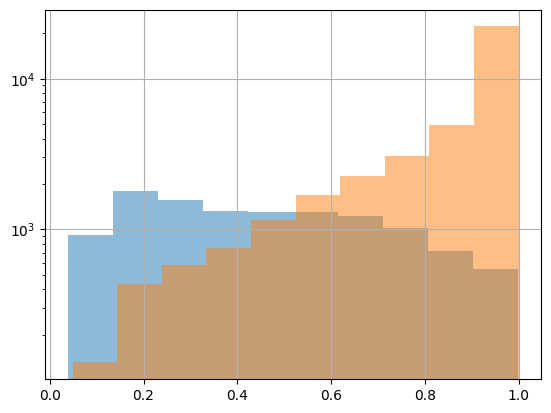

In [27]:
ax = df[df["target"] > 0].pred.hist(log=True, alpha=0.5)
df[df["target"] == 0].pred.hist(log=True, alpha=0.5, ax=ax)

You see, it is easy to do a classification using Cyclic Boosting and it works!